# NARX сеть

Идея NARX сети (Nonlinear AutoRegression with eXternal input, нелинейная авторегрессия с внешним входом).

Давайте позволим создавать только такие обратные связи, которые идут с выхода сети, а никаких других обратных связей нет (например, нет обратных связей со скрытого слоя и т.п.).

Сеть все-равно будет рекуррентной и, казалось бы, ничего нового мы не достигли.

Но давайте задумаемся, чему мы учим нейронную сеть?

Наша цель, сделать так, чтобы выходы сети совпадали как можно точнее с указаниями учителя, правда?

Предположим, что мы достигли этой цели, и указания учителя действительно полностью совпадают с выходами нейронной сети.

В обратной связи используются выходы сети (точнее их предыдущие, запомненные значения), так давайте заменим их, раз они совпадают, на указания учителя!

Указания учителя **не зависят** от весов, ведь это данные которые мы собираем сами. И наша рекуррентная сеть превращается в обычную многослойную сеть, на вход которой подаются задержанные значения указаний учителя. А такие, не рекуррентные, сети мы умеем обучать эффективно.

Конечно, предположение, что выходы совпадают с указаниями учителя это лишь предположение. Но это наша цель, значит мы можем на время обучения забыть об этом различии, и если сеть обучится хорошо, то предположение станет правдивым.

В целом NARX сеть работает так:

- для обучения заменяем выходы сети на указания учителя,
- получается сеть без обратной связи, разомкнутая (такой режим работы так и называется, разомкнутый цикл, open-loop), обучаем ее как обычную многослойную сеть,
- после обучения, если оно хорошее, заменим обратно указания учителя на выход сети, получим сеть с обратной связью, уже обученную. Такой режим работы называется замкнутый цикл, closed-loop.

Теперь можем использовать обученную рекуррентную сеть. А если надо, то дообучить ее еще немного как рекуррентную.

Конечно, можно было бы обучать сеть изначально с обратной связью в замкнутом цикле, но, как вы понимаете, обучение рекуррентной сети гораздо-гораздо сложнее, ведь мы обязаны разворачивать ее во времени.

А разомкнутая сеть в этом не нуждается, мы проводим обратное распространение только по слоям, но не по времени в развертке.

Практика показала высокую эффективность обучения по разомкнутому циклу. Понятно и ограничение, что мы можем использовать только обратные связи с выхода сети, ведь только их мы можем заменить на указания учителя.











![img](https://drive.google.com/uc?id=11UsMLharx8DlOeVYCs1ZaNGpdwvs6OFk)

**Рисунок.** Слева - замкнутый цикл, справа - разомкнутый. Квадратиками $q^{-1}$ обозначены задержки на один такт по времени. k - текущее время, x(k) - текущий вход, y(k) - текущее указание учителя для выхода, $\hat{y}(k) $ - текущий выход сети.

Кстати, внутри может использоваться любая сеть прямого распространения, но обычно это многослойный персептрон.




# NARX сеть в Sysidentpy

Хорошая библиотека, которая позволяет делать NARX сеть (но не только ее) это [sysidentpy](https://github.com/wilsonrljr/sysidentpy). Она использует PyTorch для нейронных сетей, а в целом синтаксис похож и на sklearn. Собственно говоря, эта библиотека и занимается обучением сети по разомкнутому циклу, а потом замыкает его.

Установим библиотеку. При первой установке могут возникнуть не критичные ошибки и потребуется перезагрузка ядра "тетрадки", это не страшно, нажмите кнопку Restart Runtime, а затем продолжите работу.

In [1]:
# установка
!pip install sysidentpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 2.2 MB/s eta 0:00:00


In [1]:
# подключим библиотеки
from torch import nn # для нейронных сетей
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sysidentpy.metrics import mean_squared_error # функция ошибки
from sysidentpy.utils.generate_data import get_siso_data # функция для генерации данных примера
from sysidentpy.neural_network import NARXNN # сеть NARX

from sysidentpy.basis_function._basis_function import Polynomial # функции активации
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results #  рисование
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation # расчет корреляции
from sysidentpy.utils.narmax_tools import regressor_code

import torch

In [2]:
# Для GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


## Пример данных

Для примера попробуем построить модель, которая описывается следующей формулой:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$.

Если флаг *colored_noise* выставлен в True, то:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$,

здесь $x$  равномерно распределенная случайная величина,  $\nu$ случайная величина с распределением Гаусса со средним $\mu=0$ и разбросом $\sigma=0.1$

Создадим данные, это примеры входов x и выходов y, разделив их на обучающие (первые 80% отсчетов времени и тестовые последние 20% отсчетов времени).

Это нелинейная формула, довольно сложная, устанавливает не только взаимосвязь между временными отсчетами, но и добавляет шум. Такого рода формулами описываются и реальные объекты.

Здесь мы предполагаем, что формулу взаимосвязи мы не знаем, а можем только получить измеренные значения входов и выходов. Наша цель - спрогнозировать выход при других входах, что и означает построить хорошую модель.

In [3]:
#  создаем данные
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000, # число временных отсчетов
                                                   colored_noise=False, # шум
                                                   sigma=0.01, # разброс шума
                                                   train_percentage=80) # процент данных для обучения

## Параметры NARX, функции ошибки, оптимизатора

В [NARXNN](https://sysidentpy.org/examples/narx_neural_network/) сети мы должны задавать число задержек для входа и выхода, на сколько отсчетов мы запоминаем их значения. Выбор конкретного числа зависит от задачи, для нашего примера мы понимаем, что зависимость есть как минимум на два такта - текущий и предыдущий.  

Для функции ошибки можно выбрать любую из [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html#loss-functions). Для регрессии логично выбрать MSE.

Опции оптимизатора также задаются из [torch.optim.](https://pytorch.org/docs/stable/optim.html).



In [4]:
xlag=2
ylag=4
basis_function = Polynomial(degree=1) # базисные функции
# создаем NARX сеть
narx_net = NARXNN(ylag=ylag, #  максимальная задержка выхода
                  xlag=xlag, #  максимальная задержка входа
                  basis_function=basis_function,
                  model_type="NARMAX",
                  loss_func='mse_loss', # функция ошибки
                  optimizer='Adam', # метод обучения
                  epochs=200, # количество эпох
                  device=device,
                  verbose=True, # показывать ли информацию обучения
                  optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # параметры оптимизатора
)

При выбранных величинах задержек $ylag=4$ and $xlag=2$, получаем матрицу регрессии из 6 элементов. Библиотека сама создаст необходимые данные (входы и указания учителя) с задержками, нам не надо об этом задумываться.

Можно узнать сколько элементов в матрице регрессии:

In [5]:

basis_function = Polynomial(degree=1)
regressors = regressor_code(X=x_train,
    xlag=xlag,
    ylag=ylag,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function
)
n_features = regressors.shape[0] # число входов
n_features

6

## Создание внутренней сети для NARX

Надо указать, какая именно (разомкнутая) сеть будет использоваться в NARX сети. Создадим ее, например, как класс, определив метод `__init__` и `forward()` используя слои PyTorch.

In [6]:
# разомкнутая сеть
class NARX(nn.Module): # базовый класс
    def __init__(self,regressor_size=None): # инициализация
        super().__init__()
        # слои
        self.lin = nn.Linear(regressor_size, 10) # линейный с 10 нейронами и 4 входами
        self.lin2 = nn.Linear(10, 10) # линейный с 10 нейронами и 10 входами
        self.lin3 = nn.Linear(10, 1) # линейный с 1 нейроном и 10 входами
        self.tanh = nn.Tanh() # функций активации, пусть будет одинаковая для всех скрытых слоев
    # расчет выходов
    def forward(self, xb): # принимает вход
        z = self.lin(xb) # выход первого слоя
        z = self.tanh(z) # активация его
        z = self.lin2(z) # второй слой
        z = self.tanh(z) # активация
        z = self.lin3(z) # третий слой, ему активацию не делаем
        return z

Имея такой класс, укажем его в поле `.net` NARX сети.

In [7]:
# указываем используемую разомкнутую сеть
narx_net.net = NARX(n_features)

In [8]:
# на GPU если есть
narx_net.net.to(torch.device(device))


NARX(
  (lin): Linear(in_features=6, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=1, bias=True)
  (tanh): Tanh()
)

## Обучение Fit и предсказание Predict

Обучение и предсказание выполняются уже известными нам методами `fit` и `predict`:

In [9]:
# обучение (проверочные нужны если указан verbose)
narx_net.fit(X=x_train, y=y_train, X_test=x_valid, y_test=y_valid)

Для предсказания указываем примеры входов (первый аргумент) и **начальные значения** выходов, с которых и будет идти прогноз. Этих начальных значений должно быть столько, сколько задержек используется для выходов. Вообще, от них тоже будет зависеть качество прогноза. Но в нашем простом примере начальные значения не сильно влияют на качество, проверьте.
  

In [10]:
yhat = narx_net.predict(X=x_valid, y=y_valid[0:ylag]) # предсказание, первый аргумент - входы, второй - начальные значения выходов.

Можно нарисовать предсказания. Дополнительные графики показывают автокорреляцию отклонений и взаимную корреляцию между входами и отклонениями. Отклонение - разность между предсказанным и действительным значением.  



MSE:  0.00028670323414194706


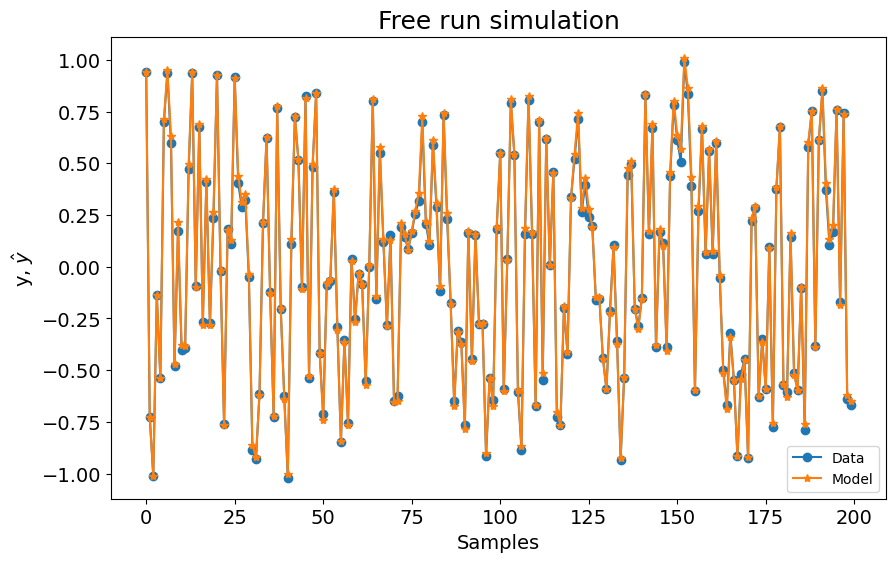

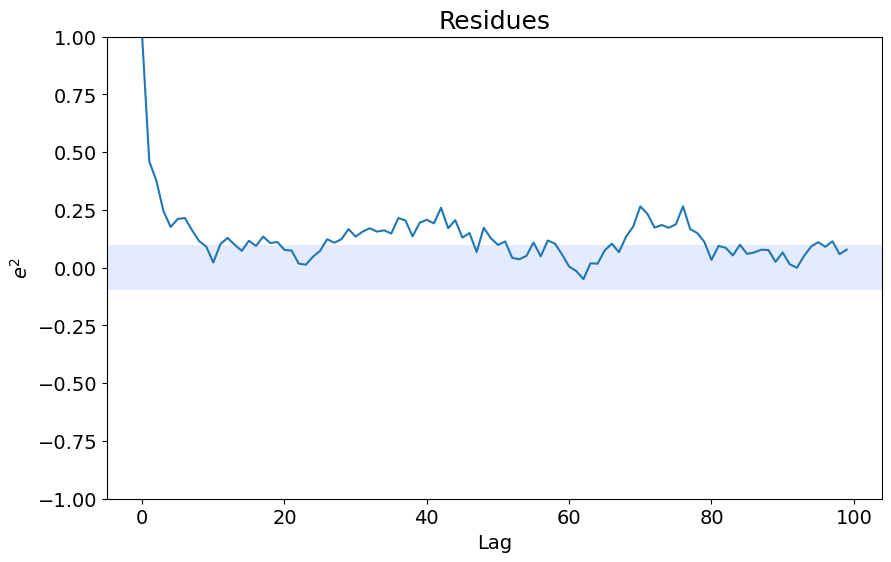

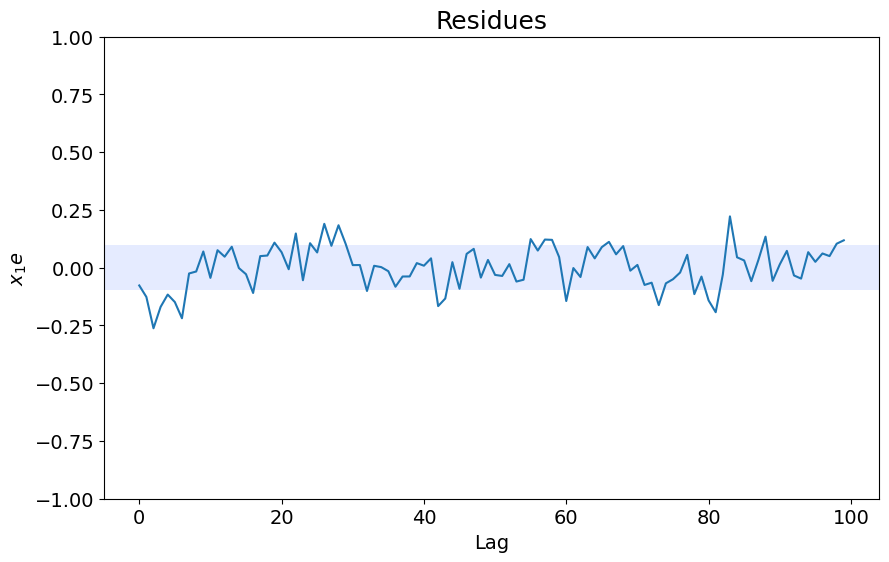

In [11]:
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

Что ж, у нас получилось замечательно предсказать выходные значения.

Для упражнения попробуйте

а) поменять разомкнутую сеть
б) изменить параметры обучения
в) число задержек
г) начальные значения выходов для предсказания.

# Ссылки

Использованы и адаптированы материалы:

https://github.com/wilsonrljr/sysidentpy/blob/master/examples/narx_neural_network.ipynb

[Parallel Training Considered Harmful?: Comparing series-parallel and parallel feedforward
network training](https://arxiv.org/pdf/1706.07119.pdf)